In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter,StrMethodFormatter,ScalarFormatter
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

In [2]:
portfolio = pd.read_json(r'C:\Desktop\portfolio.json', orient='records', lines=True)
profile = pd.read_json(r'C:\Desktop\profile.json', orient='records', lines=True)
transcript = pd.read_json(r'C:\Desktop\transcript.json', orient='records', lines=True)

In [3]:
df=pd.DataFrame(transcript['value'].values.tolist(),index=transcript.index)

In [4]:
transcript=transcript.merge(df,left_index=True, right_index=True)

In [5]:
#one hot encode channels
mlb = MultiLabelBinarizer()
channel = pd.DataFrame(mlb.fit_transform(portfolio['channels']),columns=mlb.classes_, index=portfolio.index)

In [6]:
portfolio=portfolio.merge(channel,left_index=True, right_index=True)

In [7]:
transcript=transcript.merge(portfolio, left_on='offer_id', right_on='id', how='left')

In [8]:
transcript=transcript.merge(profile, left_on='person', right_on='id', how='left')

In [9]:
transcript=transcript.merge(portfolio, left_on='offer id', right_on='id', how='left')

In [10]:
transcript_a=transcript[transcript['event']=='offer completed']\
.groupby(['offer_type_x','difficulty_x','reward_x','duration_x'])['event'].count()

In [11]:
transcript_a=transcript_a.reset_index()

In [12]:
transcript_a

,offer_type_x,difficulty_x,reward_x,duration_x,event
0,bogo,5.0,5.0,5.0,4296
1,bogo,5.0,5.0,7.0,4354
2,bogo,10.0,10.0,5.0,3331
3,bogo,10.0,10.0,7.0,3688
4,discount,7.0,3.0,7.0,5156
5,discount,10.0,2.0,7.0,4017
6,discount,10.0,2.0,10.0,5317
7,discount,20.0,5.0,10.0,3420


In [13]:
transcript_a=transcript_a.rename(columns={"offer_type_x": "offer_type",\
                             "difficulty_x": "difficulty",\
                             "reward_x": "reward",\
                             "duration_x":"duration",
                             "event":"Number of Offers Completed"})


In [14]:
transcript_b=transcript[(transcript['event']=='offer received') & (transcript['offer_type_y']!='informational')]\
.groupby(['offer_type_y','difficulty_y','reward','duration_y'])['event'].count()
# I omit O because it's unclear what gender it is so would not inform future targeting strategy

In [15]:
transcript_b=transcript_b.reset_index()

In [16]:
transcript_b=transcript_b.rename(columns={"offer_type_y": "offer_type",\
                             "difficulty_y": "difficulty",\
                             "duration_y":"duration",
                             "event":"Number of Offers Received"})


In [17]:
transcript_b

,offer_type,difficulty,reward,duration,Number of Offers Received
0,bogo,5.0,5.0,5.0,7571
1,bogo,5.0,5.0,7.0,7677
2,bogo,10.0,10.0,5.0,7593
3,bogo,10.0,10.0,7.0,7658
4,discount,7.0,3.0,7.0,7646
5,discount,10.0,2.0,7.0,7632
6,discount,10.0,2.0,10.0,7597
7,discount,20.0,5.0,10.0,7668


In [18]:
#inner join transcript_a and transcript_b on index
response=pd.merge(transcript_a, transcript_b, left_index=True, right_index=True)

In [19]:
response=response.drop(columns=['offer_type_y', 'difficulty_y','reward_y','duration_y'])\
.rename(columns={"offer_type_x": "offer_type",\
                             "difficulty_x": "difficulty",\
                             "reward_x": "reward",\
                             "duration_x":"duration"})

In [20]:
response['Percent of Offers Completed/Offers Received']=\
round((response['Number of Offers Completed']/response['Number of Offers Received']*100),1)

In [21]:
response['Offer Type Variant']=response['offer_type'].str.upper()\
+": "+ "Spend: "+response['difficulty'].astype(str)\
+", Reward: "+response['reward'].astype(str)\
+", Duration: "+response['duration'].astype(str)
response
response=response.set_index('Offer Type Variant')

In [22]:
response=response.drop(columns=['offer_type', 'difficulty','reward','duration'])
response

,Number of Offers Completed,Number of Offers Received,Percent of Offers Completed/Offers Received
Offer Type Variant,,,
"BOGO: Spend: 5.0, Reward: 5.0, Duration: 5.0",4296,7571,56.7
"BOGO: Spend: 5.0, Reward: 5.0, Duration: 7.0",4354,7677,56.7
"BOGO: Spend: 10.0, Reward: 10.0, Duration: 5.0",3331,7593,43.9
"BOGO: Spend: 10.0, Reward: 10.0, Duration: 7.0",3688,7658,48.2
"DISCOUNT: Spend: 7.0, Reward: 3.0, Duration: 7.0",5156,7646,67.4
"DISCOUNT: Spend: 10.0, Reward: 2.0, Duration: 7.0",4017,7632,52.6
"DISCOUNT: Spend: 10.0, Reward: 2.0, Duration: 10.0",5317,7597,70.0
"DISCOUNT: Spend: 20.0, Reward: 5.0, Duration: 10.0",3420,7668,44.6


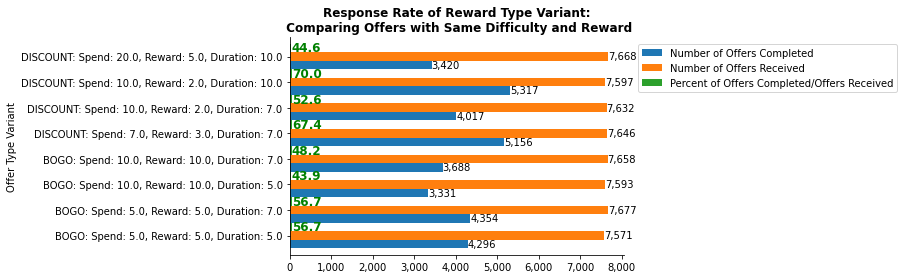

In [23]:
ax=response.plot(kind = "barh", width=1,legend=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.bar_label(ax.containers[0],fmt='{:,.0f}')
ax.bar_label(ax.containers[1],fmt='{:,.0f}')
ax.bar_label(ax.containers[2],fmt='{:,.1f}',label_type='edge',color='green',fontsize=12,
             weight='bold')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.legend(response, loc=(1.04, .75))
plt.title('Response Rate of Reward Type Variant:\n Comparing Offers with Same Difficulty and Reward', weight='bold')
plt.show()

In [24]:
response=response.sort_values('Percent of Offers Completed/Offers Received')

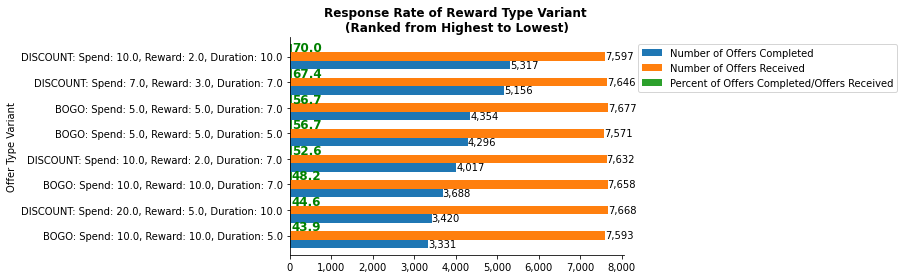

In [25]:
ax=response.plot(kind = "barh", width=1,legend=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.bar_label(ax.containers[0],fmt='{:,.0f}')
ax.bar_label(ax.containers[1],fmt='{:,.0f}')
ax.bar_label(ax.containers[2],fmt='{:,.1f}',label_type='edge',color='green',fontsize=12,
             weight='bold')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.legend(response, loc=(1.04, .75))
plt.title('Response Rate of Reward Type Variant \n(Ranked from Highest to Lowest)', weight='bold')
plt.show()

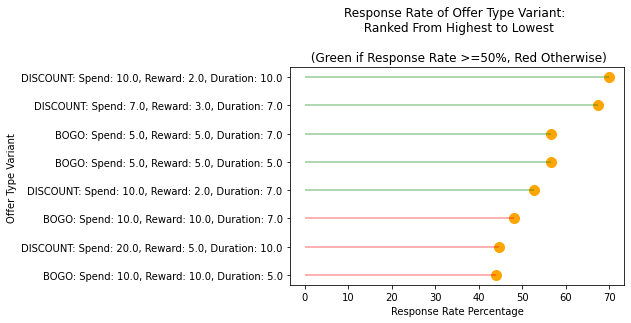

In [26]:
#Create leaderboard by Offer Type Variant
# Reorder it based on values so it would display highest to lowest response rate.
ordered_df = response.sort_values(by='Percent of Offers Completed/Offers Received')
my_range=range(1,len(response.index)+1)
my_color=np.where(response['Percent of Offers Completed/Offers Received']<50, 'red', 'green')

plt.hlines(y=my_range, xmin=0, 
           xmax=response['Percent of Offers Completed/Offers Received'], 
           color=my_color, alpha=0.4)
plt.scatter(response['Percent of Offers Completed/Offers Received'], my_range, alpha=1, color=['orange'], s=100)

# Add title and axis names
plt.yticks(my_range, response.index)
plt.title("Response Rate of Offer Type Variant: \n Ranked From Highest to Lowest\n\n (Green if Response Rate >=50%, Red Otherwise)")
plt.xlabel('Response Rate Percentage')
plt.ylabel('Offer Type Variant ')
plt.show()

#https://www.python-graph-gallery.com/181-custom-lollipop-plot